# Bayesian Neural Networks

Following https://turing.ml/dev/tutorials/03-bayesian-neural-network/

## Generation

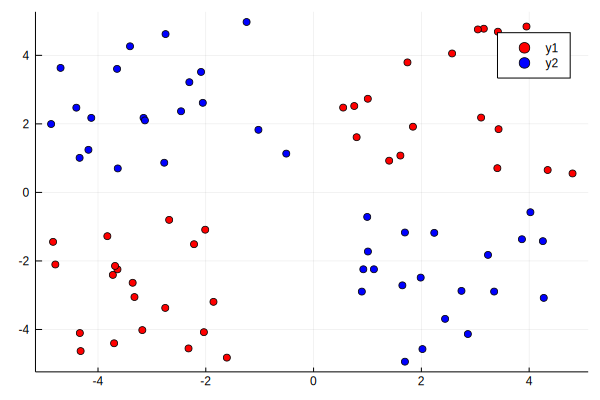

In [2]:
# Number of points to generate.
N = 80
M = round(Int, N / 4)
Random.seed!(1234)

# Generate artificial data.
x1s = rand(M) * 4.5; x2s = rand(M) * 4.5; 
xt1s = Array([[x1s[i] + 0.5; x2s[i] + 0.5] for i = 1:M])
x1s = rand(M) * 4.5; x2s = rand(M) * 4.5; 
append!(xt1s, Array([[x1s[i] - 5; x2s[i] - 5] for i = 1:M]))

x1s = rand(M) * 4.5; x2s = rand(M) * 4.5; 
xt0s = Array([[x1s[i] + 0.5; x2s[i] - 5] for i = 1:M])
x1s = rand(M) * 4.5; x2s = rand(M) * 4.5; 
append!(xt0s, Array([[x1s[i] - 5; x2s[i] + 0.5] for i = 1:M]))

# Store all the data for later.
xs = [xt1s; xt0s]
ts = [ones(2*M); zeros(2*M)]

# Plot data points.
function plot_data()
    x1 = map(e -> e[1], xt1s)
    y1 = map(e -> e[2], xt1s)
    x2 = map(e -> e[1], xt0s)
    y2 = map(e -> e[2], xt0s)

    Plots.scatter(x1,y1, color="red", clim = (0,1))
    Plots.scatter!(x2, y2, color="blue", clim = (0,1))
end

plot_data()

## Create NN

In [1]:
# Import libraries.
using Turing, Flux, Plots, Random, ReverseDiff

# Hide sampling progress.
Turing.setprogress!(false);

# Use reverse_diff due to the number of parameters in neural networks.
Turing.setadbackend(:reversediff);

┌ Info: [Turing]: progress logging is disabled globally
└ @ Turing /home/anatoly/.julia/packages/Turing/YGtAo/src/Turing.jl:22
┌ Info: [AdvancedVI]: global PROGRESS is set as false
└ @ AdvancedVI /home/anatoly/.julia/packages/AdvancedVI/yCVq7/src/AdvancedVI.jl:15


In [3]:
# Turn a vector into a set of weights and biases.
function unpack(nn_params::AbstractVector)
    W₁ = reshape(nn_params[1:6], 3, 2);   
    b₁ = nn_params[7:9]
    
    W₂ = reshape(nn_params[10:15], 2, 3); 
    b₂ = nn_params[16:17]
    
    Wₒ = reshape(nn_params[18:19], 1, 2); 
    bₒ = nn_params[20:20]
    return W₁, b₁, W₂, b₂, Wₒ, bₒ
end

# Construct a neural network using Flux and return a predicted value.
function nn_forward(xs, nn_params::AbstractVector)
    W₁, b₁, W₂, b₂, Wₒ, bₒ = unpack(nn_params)
    nn = Chain(Dense(W₁, b₁, tanh),
               Dense(W₂, b₂, tanh),
               Dense(Wₒ, bₒ, σ))
    return nn(xs)
end;

In [4]:
# Create a regularization term and a Gaussain prior variance term.
alpha = 0.09
sig = sqrt(1.0 / alpha)

# Specify the probabalistic model.
@model function bayes_nn(xs, ts)
    # Create the weight and bias vector.
    nn_params ~ MvNormal(zeros(20), sig .* ones(20))
    
    # Calculate predictions for the inputs given the weights
    # and biases in theta.
    preds = nn_forward(xs, nn_params)
    
    # Observe each prediction.
    for i = 1:length(ts)
        ts[i] ~ Bernoulli(preds[i])
    end
end;

## Sample NN

In [5]:
# Perform inference.
N = 5000
ch = sample(bayes_nn(hcat(xs...), ts), HMC(0.05, 4), N);

In [6]:
# Extract all weight and bias parameters.
theta = MCMCChains.group(ch, :nn_params).value;

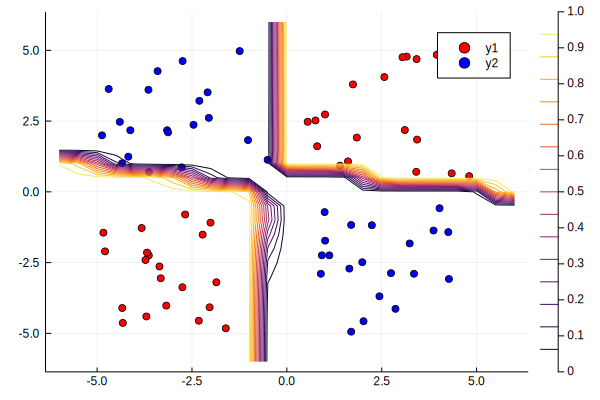

In [7]:
# Plot the data we have.
plot_data()

# Find the index that provided the highest log posterior in the chain.
_, i = findmax(ch[:lp])

# Extract the max row value from i.
i = i.I[1]

# Plot the posterior distribution with a contour plot.
x_range = collect(range(-6,stop=6,length=25))
y_range = collect(range(-6,stop=6,length=25))
Z = [nn_forward([x, y], theta[i, :])[1] for x=x_range, y=y_range]
contour!(x_range, y_range, Z)

In [8]:
# Return the average predicted value across
# multiple weights.
function nn_predict(x, theta, num)
    mean([nn_forward(x, theta[i,:])[1] for i in 1:10:num])
end;

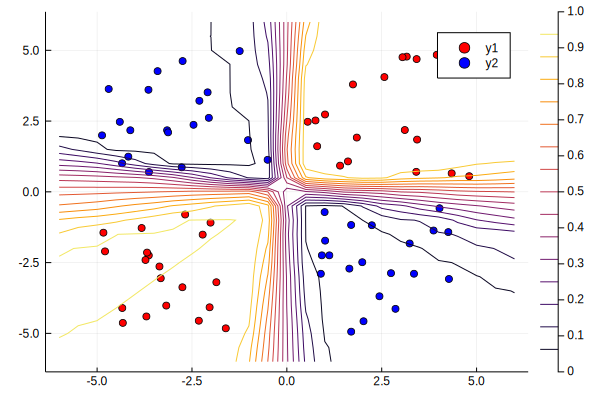

In [9]:
# Plot the average prediction.
plot_data()

n_end = 1500
x_range = collect(range(-6,stop=6,length=25))
y_range = collect(range(-6,stop=6,length=25))
Z = [nn_predict([x, y], theta, n_end)[1] for x=x_range, y=y_range]
contour!(x_range, y_range, Z)

┌ Info: Saved animation to 
│   fn = /home/anatoly/repos/personal/m5-competition/nb/turing/tmp.gif
└ @ Plots /home/anatoly/.julia/packages/Plots/cc8wh/src/animation.jl:98


Plots.AnimatedGif("/home/anatoly/repos/personal/m5-competition/nb/turing/tmp.gif")
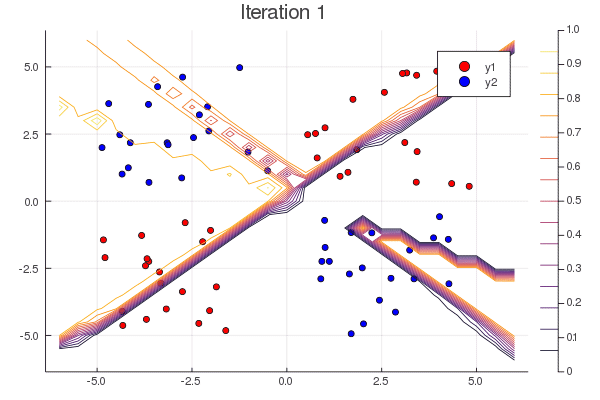

In [10]:
# Number of iterations to plot.
n_end = 500

anim = @gif for i=1:n_end
    plot_data()
    Z = [nn_forward([x, y], theta[i,:])[1] for x=x_range, y=y_range]
    contour!(x_range, y_range, Z, title="Iteration $i", clim = (0,1))
end every 5

## Change Network Shape

In [17]:
# This modification of the unpack function generates a series of vectors
# given a network shape.
function unpack(θ::AbstractVector, network_shape::AbstractVector)
    index = 1
    weights = []
    biases = []
    for layer in network_shape
        rows, cols, _ = layer
        size = rows * cols
        last_index_w = size + index - 1
        last_index_b = last_index_w + rows
        push!(weights, reshape(θ[index:last_index_w], rows, cols))
        push!(biases, reshape(θ[last_index_w+1:last_index_b], rows))
        index = last_index_b + 1
    end
    return weights, biases
end

# Generate an abstract neural network given a shape, 
# and return a prediction.
function nn_forward(x, θ::AbstractVector, network_shape::AbstractVector)
    weights, biases = unpack(θ, network_shape)
    layers = []
    for i in eachindex(network_shape)
        push!(layers, Dense(weights[i],
            biases[i],
            eval(network_shape[i][3])))
    end
    nn = Chain(layers...)
    return nn(x)
end

# General Turing specification for a BNN model.
@model bayes_nn_general(xs, ts, network_shape, num_params) = begin
    θ ~ MvNormal(zeros(num_params), sig .* ones(num_params))
    preds = nn_forward(xs, θ, network_shape)
    for i = 1:length(ts)
        ts[i] ~ Bernoulli(preds[i])
    end
end

# This function makes predictions based on network shape.
function nn_predict(x, theta, num, network_shape)
    mean([nn_forward(x, theta[i,:], network_shape)[1] for i in 1:10:num])
end

;

In [18]:
# Specify the network architecture.
network_shape = [
    (3,2, :tanh),
    (2,3, :tanh), 
    (1,2, :σ)]

# Regularization, parameter variance, and total number of
# parameters.
alpha = 0.09
sig = sqrt(1.0 / alpha)
num_params = sum([i * o + i for (i, o, _) in network_shape])

# Perform inference.
num_samples = 500
ch2 = sample(bayes_nn_general(hcat(xs...), ts, network_shape, num_params), NUTS(0.65), num_samples);

┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/anatoly/.julia/packages/Turing/YGtAo/src/inference/hmc.jl:188


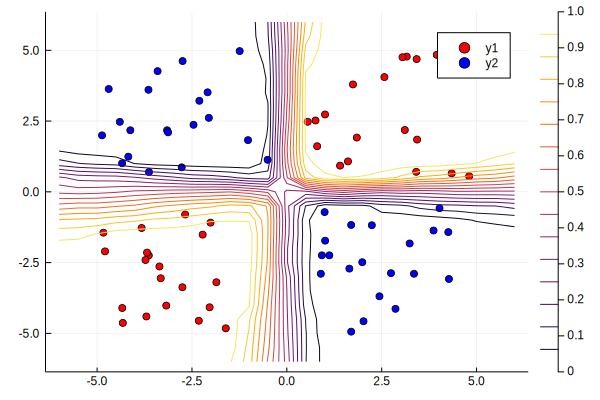

In [20]:
# Extract the θ parameters from the sampled chain.
params2 = MCMCChains.group(ch2, :θ).value

plot_data()

x_range = collect(range(-6,stop=6,length=25))
y_range = collect(range(-6,stop=6,length=25))
Z = [nn_predict([x, y], params2, length(ch2), network_shape)[1] for x=x_range, y=y_range]
contour!(x_range, y_range, Z)